##### Name: Usama Khalid
##### Email: i191236@nu.edu.pk


### 1. Downloading Dataset


In [1]:
!wget -r -np -nH --cut-dirs=3 -A mp3,wav -P data https://media.talkbank.org/ca/CallFriend/eng-n/
!mkdir graph

### 2. Importing packages and initializing variables

In [2]:
import glob
import time
import math
import librosa
import numpy as np
from itertools import groupby
from operator import itemgetter
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

noise_threshold = 0.01
speech_noise_tolerance_threshold = 0.1
data_dir = 'data/'
graph_dir='graph/'
sampling_rate = 16000
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'grey']
silence_color = 'gainsboro'

### 3. Defining speech detection

In [3]:
def is_speech(audio_data, mean_amplitude):
    noise_amplitude = mean_amplitude * noise_threshold
    return np.sum(abs(audio_data) > noise_amplitude) > (audio_data.size * (1 - speech_noise_tolerance_threshold))

### 4. Defining speech segmentation

In [4]:
def segment_audio(audio_data):
    split_ratio = math.ceil(audio_data.size / sampling_rate)
    padding = (-len(audio_data)) % split_ratio
    return np.array(np.split(np.concatenate((audio_data, np.zeros(padding))), split_ratio))

### 5. Defining Embedding extraction

In [5]:
def extract_features(signal):
    chroma_stft = librosa.feature.chroma_stft(y=signal, sr=sampling_rate)
    rms = librosa.feature.rms(y=signal)
    spec_cent = librosa.feature.spectral_centroid(y=signal, sr=sampling_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sampling_rate)
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sampling_rate)
    zcr = librosa.feature.zero_crossing_rate(signal)
    mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate)
    features = [np.mean(chroma_stft), np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff),
                np.mean(zcr)]
    for e in mfcc:
        features.append(np.mean(e))

    return features

def extract_embeddings(file_path):
    signal, _ = librosa.load(file_path, sr=sampling_rate)
    mean_amplitude = np.mean(abs(signal))
    segmented_audio = segment_audio(signal)
    filter_idx = [is_speech(audio, mean_amplitude) for audio in segmented_audio]
    embeddings = np.array([extract_features(chunk) for chunk in segmented_audio[filter_idx]])

    return embeddings, filter_idx, signal

### 6. Defining Clustering

In [12]:
def cluster_audio(embeddings):
    # Selecting optimal value of k using elbow method
    distortions = []
    K = range(1, 10)
    for k in K:
        clf = KMeans(n_clusters=k).fit(embeddings)
        clf.fit(embeddings)
        distortions.append(
            sum(np.min(cdist(embeddings, clf.cluster_centers_, 'euclidean'), axis=1)) / embeddings.shape[0])

    selected_k = K[np.argmin(np.diff(distortions)) + 1]
    clf = KMeans(n_clusters=selected_k, random_state=0).fit(embeddings)

    #Plot the elbow
    # plt.plot(K, distortions, 'bx-')
    # plt.xlabel('k')
    # plt.ylabel('Distortion')
    # plt.title('The Elbow Method showing the optimal k')
    # plt.show()

    return np.array(clf.labels_)

### 7. Defining Graph Plotting


In [7]:
def get_ranges(data):
    out = []
    for _, g in groupby(enumerate(data), lambda i_x: i_x[0] - i_x[1]):
        out.append(list(map(itemgetter(1), g)))
    return out

def graph(samples, audio_file_name, speakers):
    title = audio_file_name.split('/')[-1]
    plt.figure(figsize=(24, 4))
    plt.title(title)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')
    x = np.arange(len(samples)) / sampling_rate
    y = samples
    color_patches = []
    for key in speakers:
        speaker_start_stop = get_ranges(speakers[key])
        if key:
            color = colors[key % len(colors)]
            label = 'Speaker ' + str(key)
        else:
            color = silence_color
            label = 'Silence'
        color_patches.append(patches.Patch(color=color, label=label))
        for start_stop in speaker_start_stop:
            plt.axvspan(min(start_stop), max(start_stop), color=color, alpha=0.5)
    plt.legend(handles=color_patches)
    plt.plot(x, y)
    plt.savefig(graph_dir+'{}.svg'.format(title), bbox_inches='tight')
    plt.show()

### 8. Create graphs for all audios in data


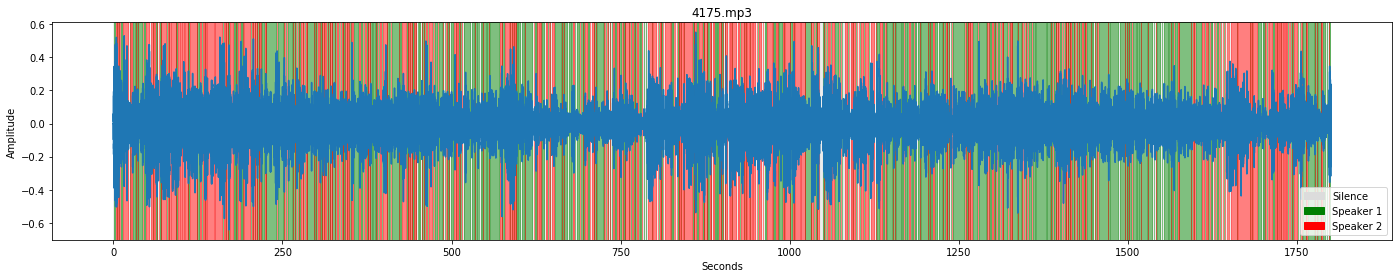

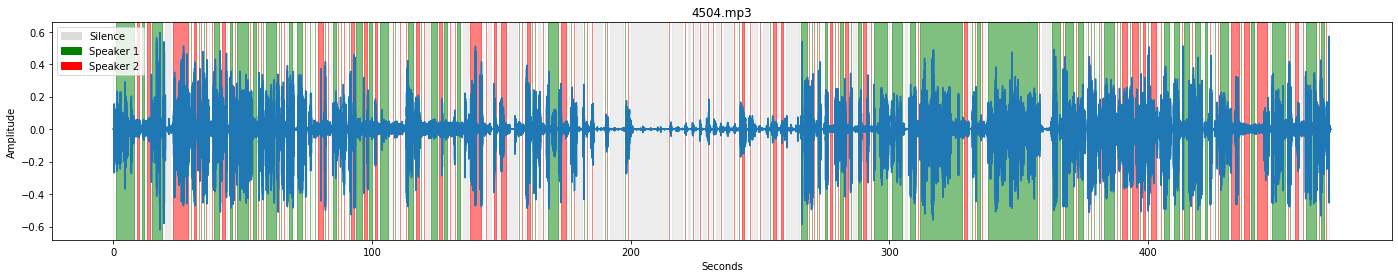

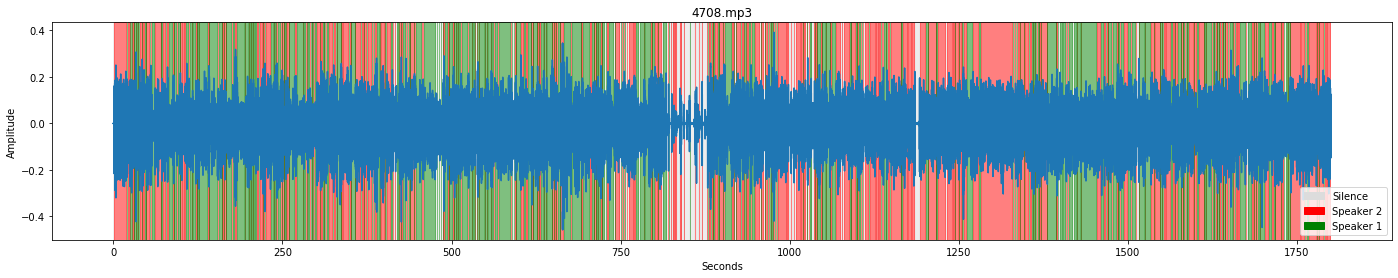

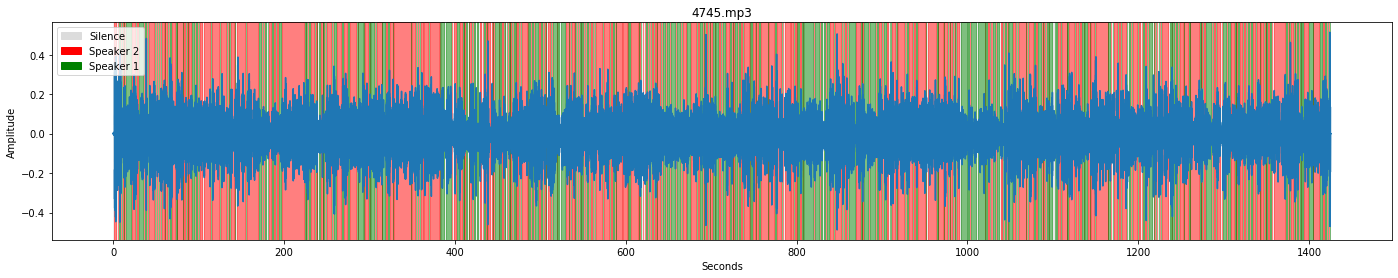

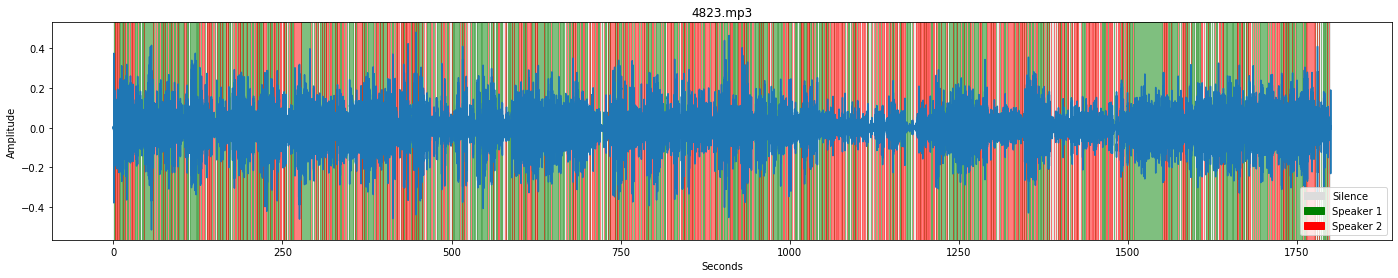

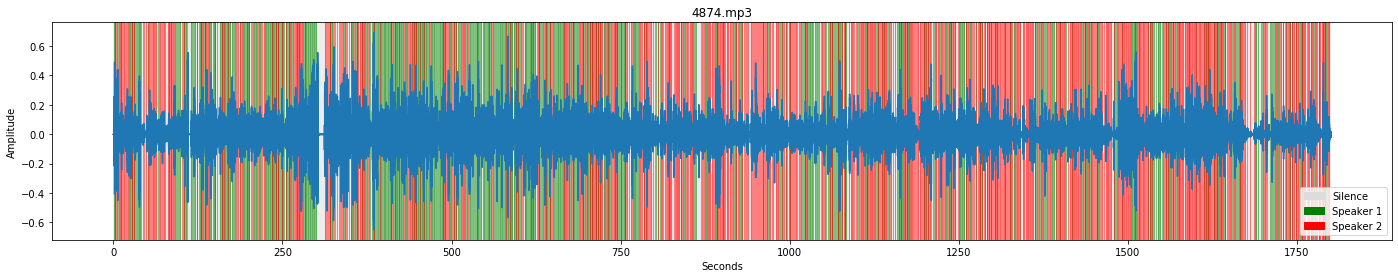

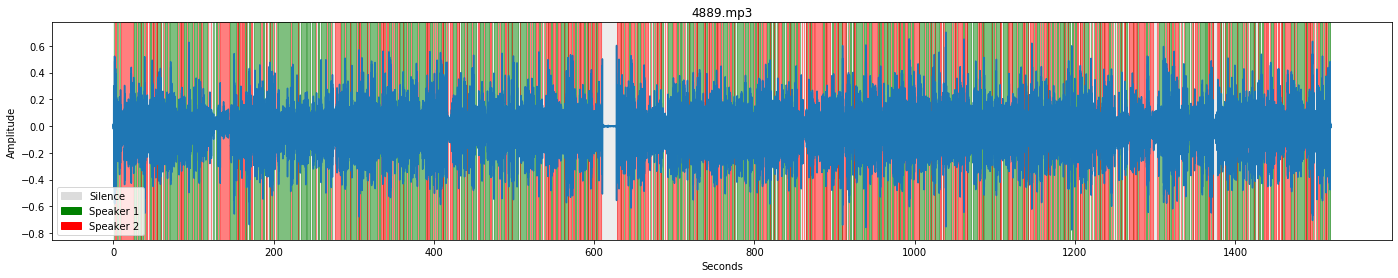

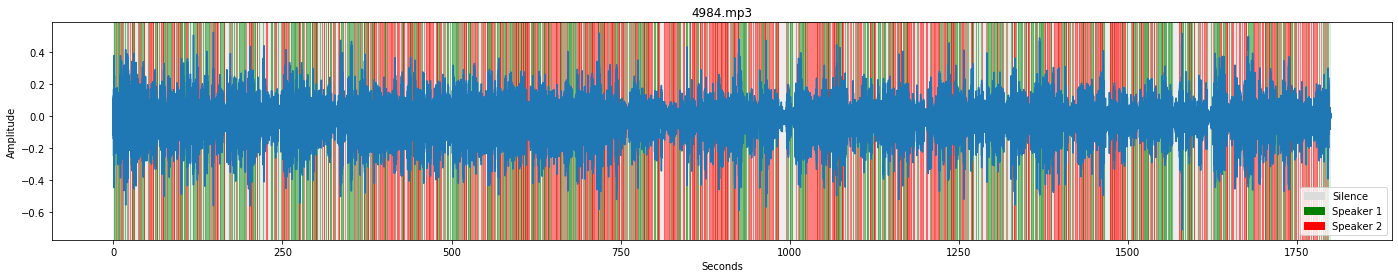

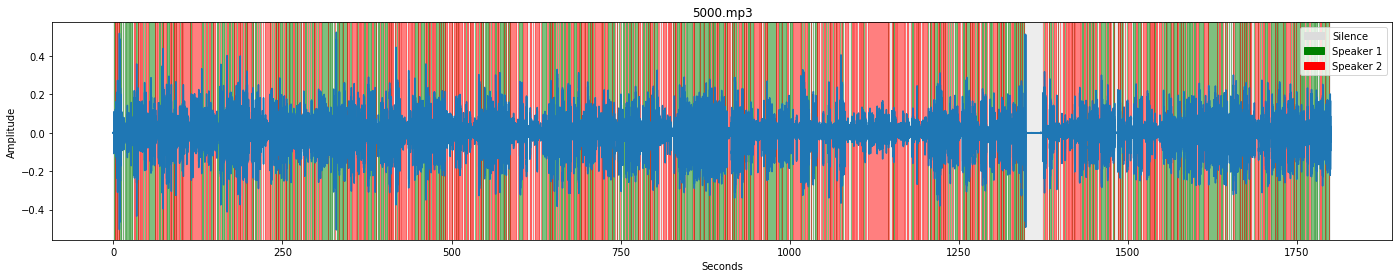

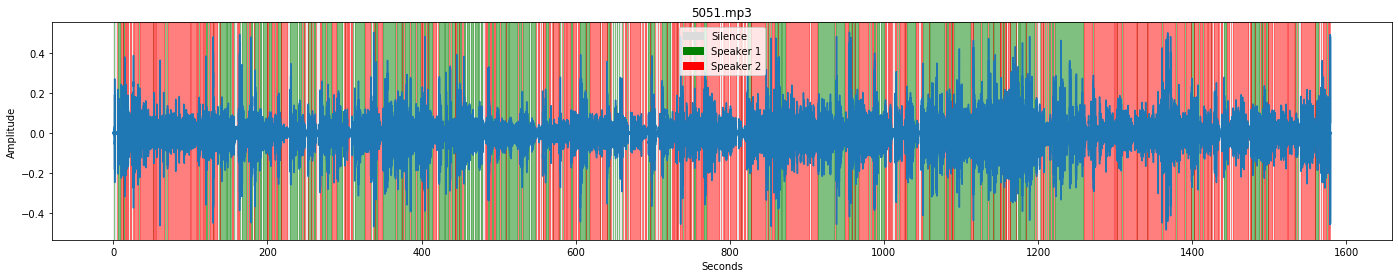

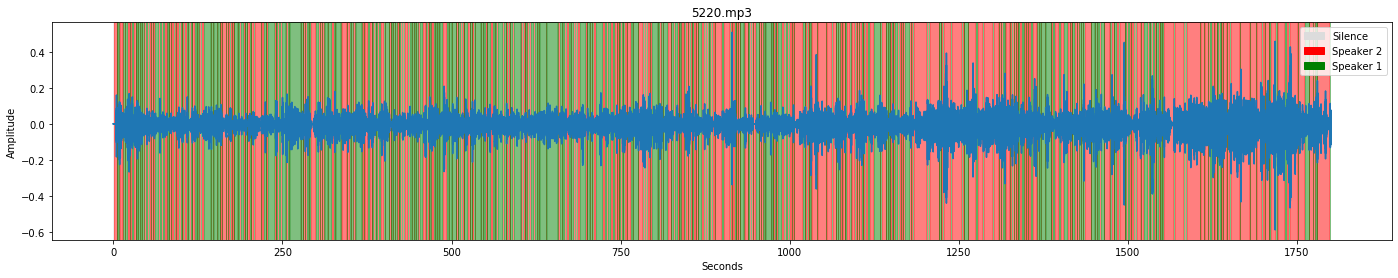

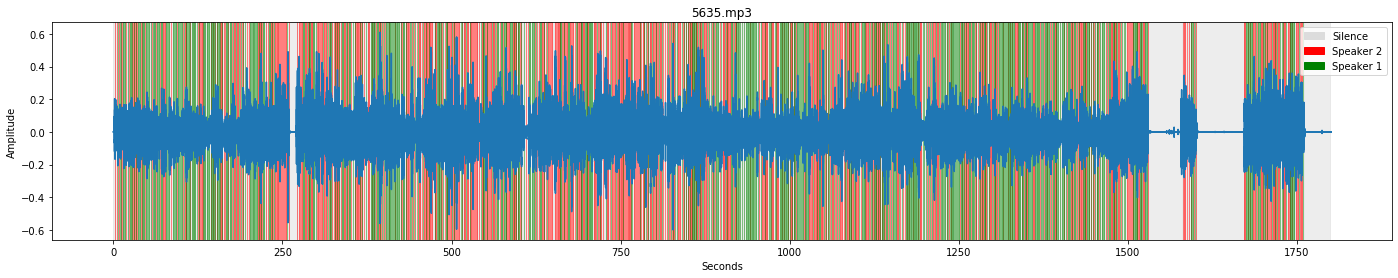

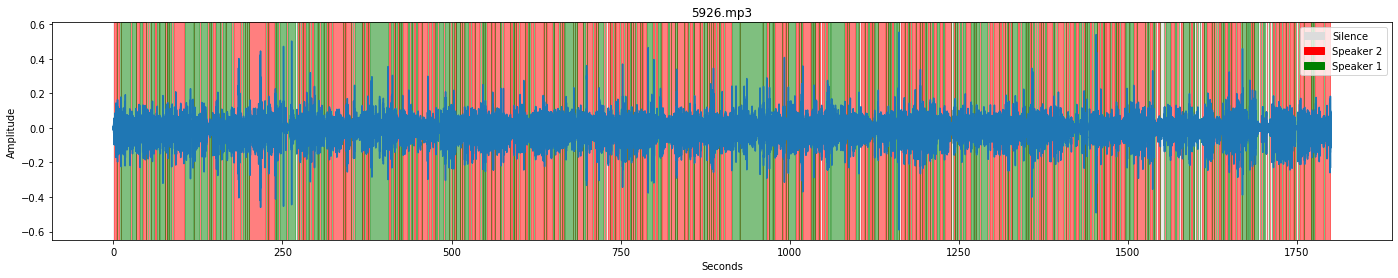

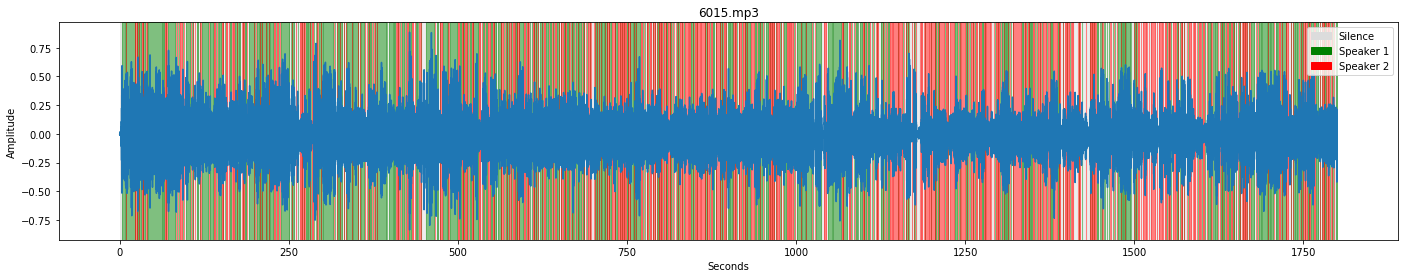

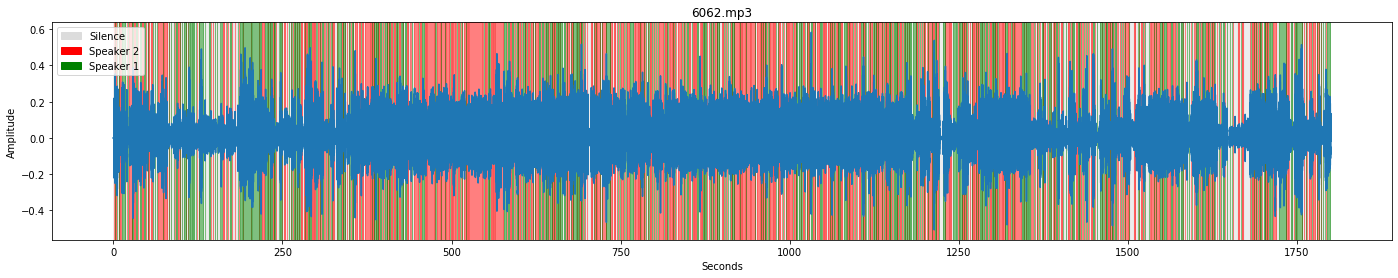

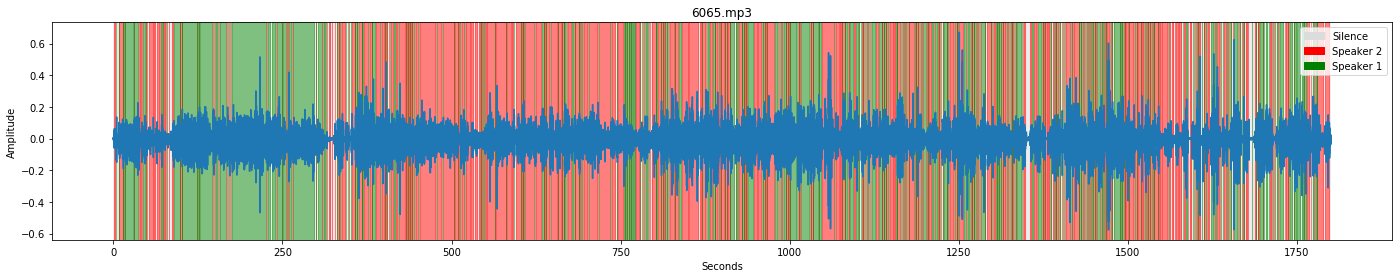

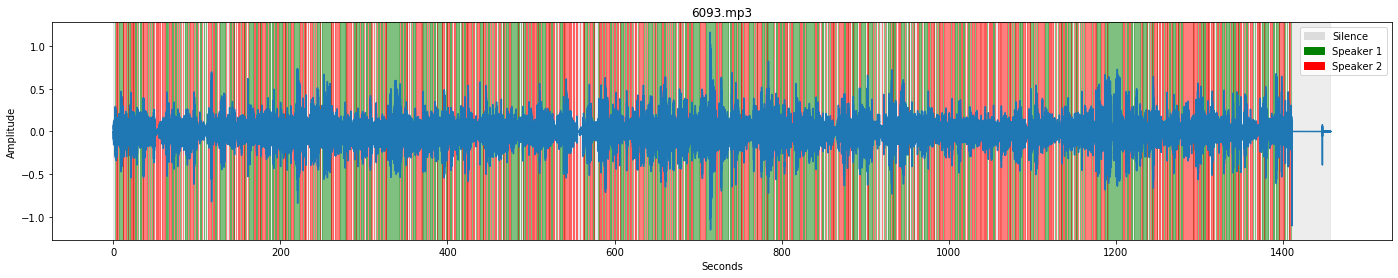

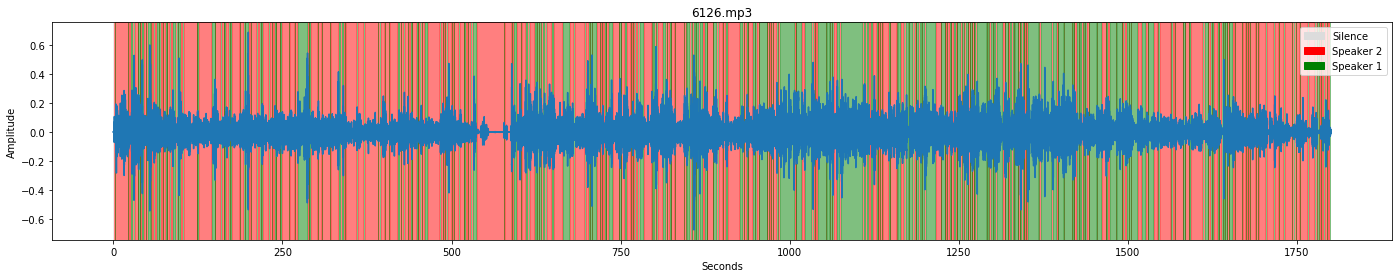

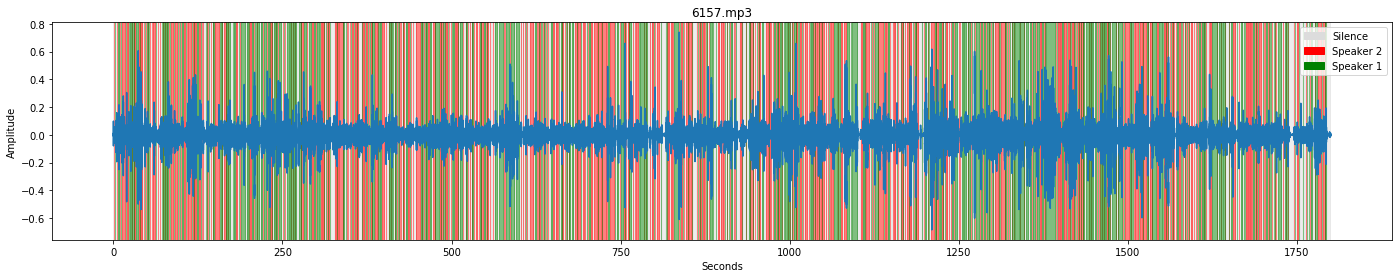

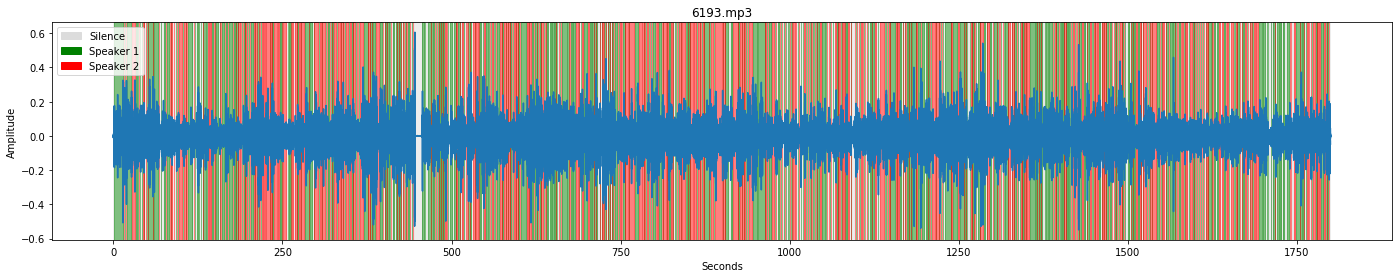

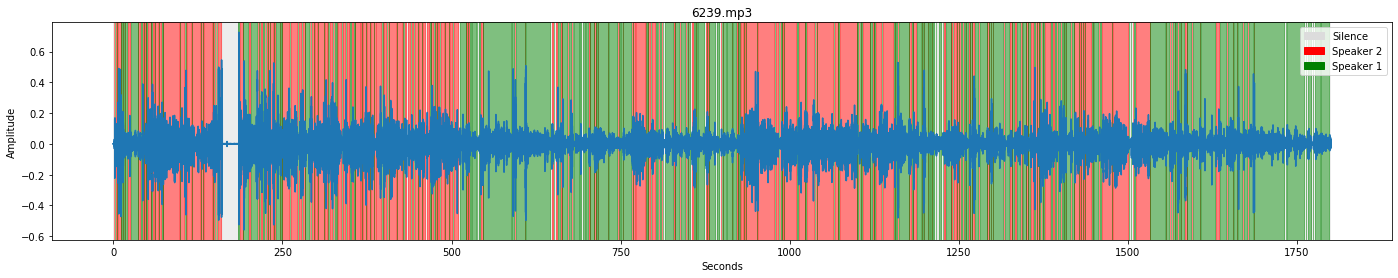

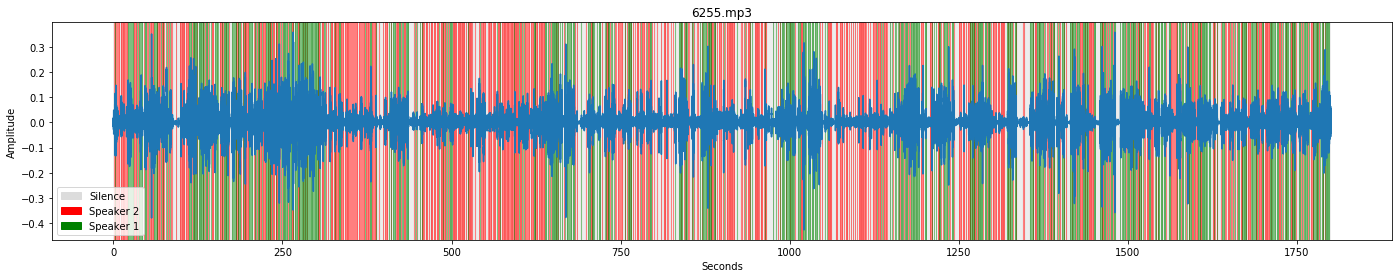

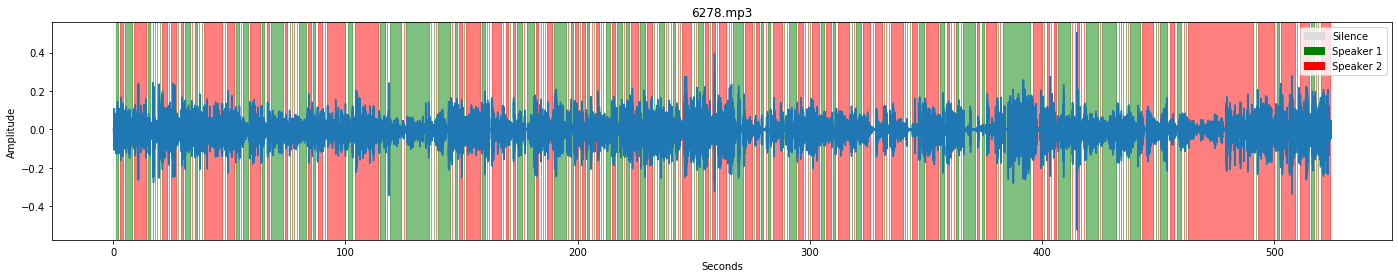

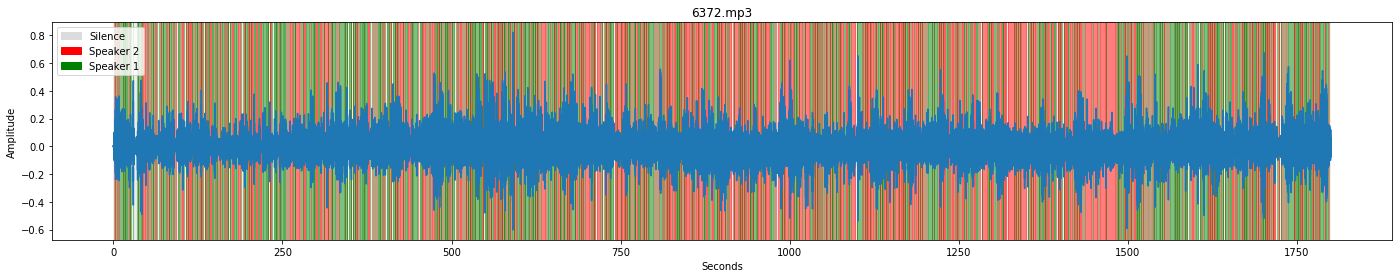

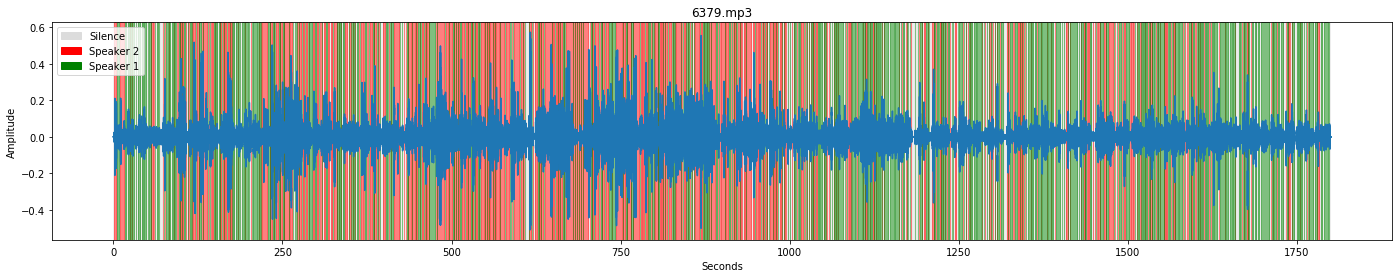

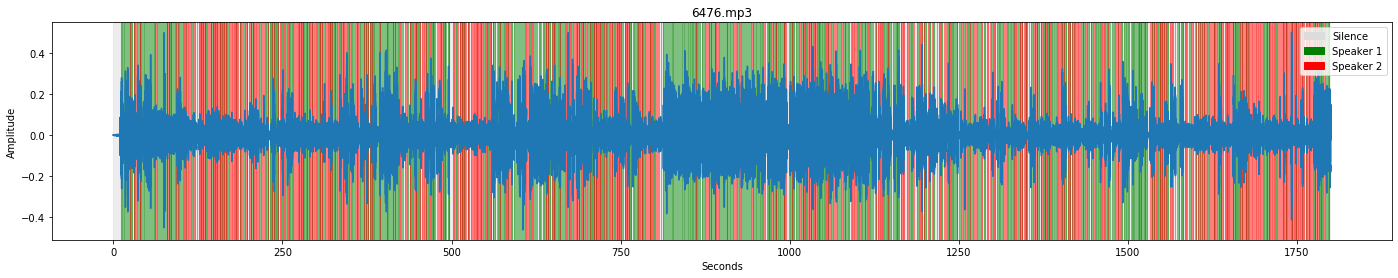

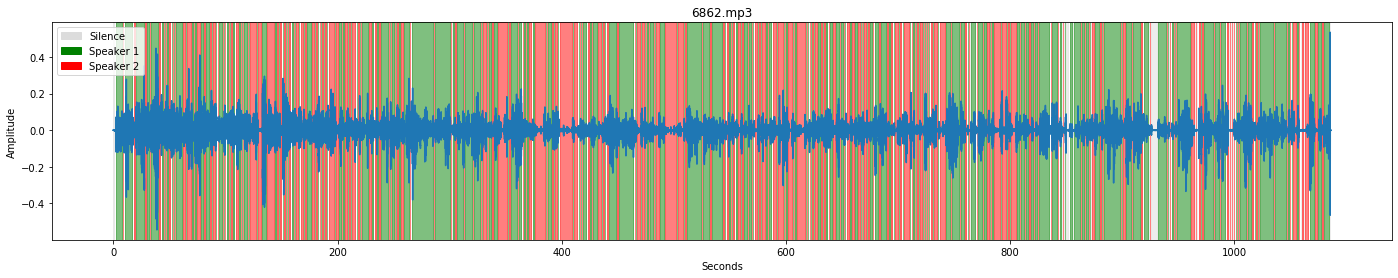

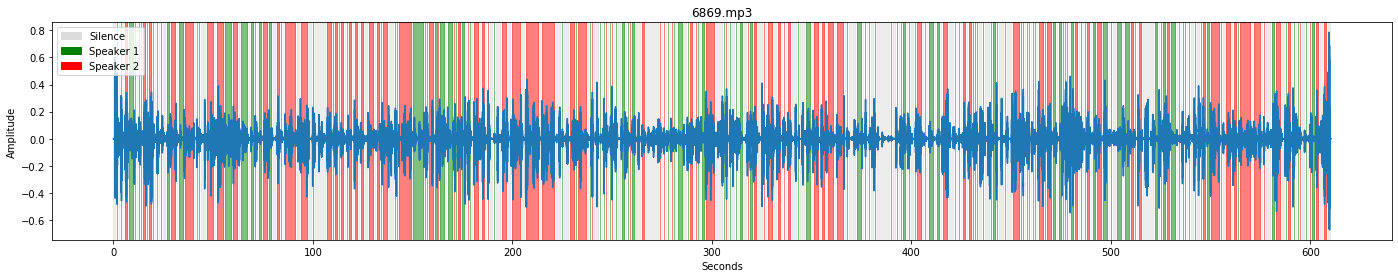

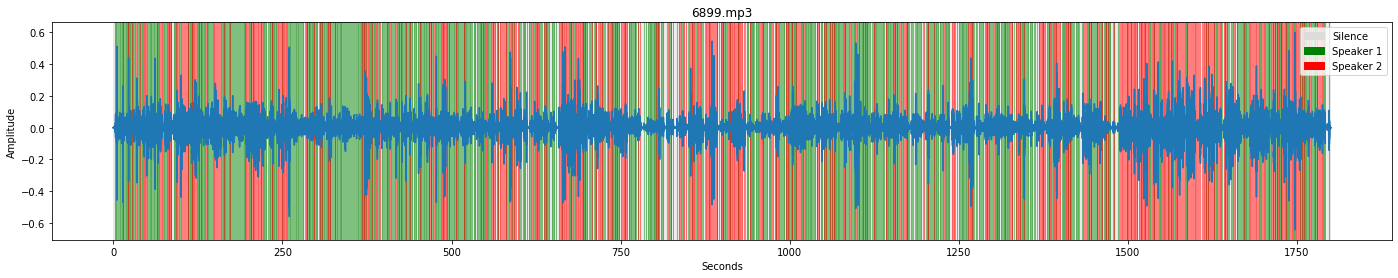

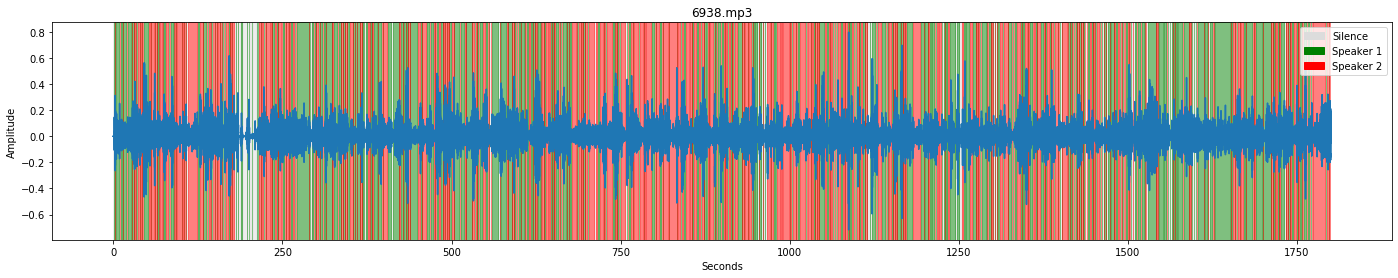

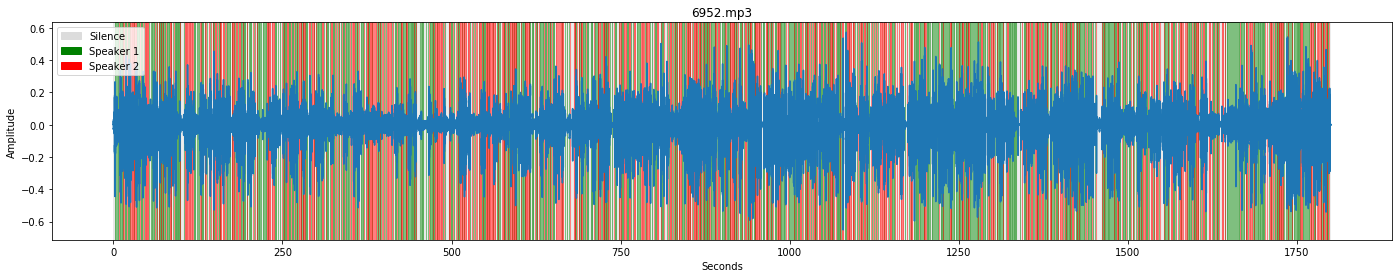

In [9]:
for file in glob.glob("data/*.mp3"):
    embedding_data, idx, audio = extract_embeddings(file)
    labels = cluster_audio(embedding_data)

    result = np.zeros(len(idx), dtype=np.int32)
    result[idx] = labels + 1

    speaker_dict = defaultdict(list)

    for i, v in enumerate(result):
        speaker_dict[v].append(i)

    graph(audio,file,speaker_dict)
